### IMPORT LIBRAIRIES

In [1]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from collections import Counter

import html

from collections import defaultdict

from wordcloud import WordCloud


from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt



from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')


# 1. Data Exploration

In [4]:
dataset = pd.read_csv('/content/train.csv')
print("Data shape = ",dataset.shape)
dataset.head()

Data shape =  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
dataset_test = pd.read_csv('/content/test.csv')
print("Data shape = ",dataset_test.shape)
dataset_test.head()

Data shape =  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_raw = pd.read_csv("train.csv")
test_raw = pd.read_csv("test.csv")

In [6]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


**La colonne "text" qu'on veut analyser n'a pas de données manquantes**

# 2.Prétraitement des données 

## 2.1 Données manquantes

In [17]:
# Obtenir le nombre total de données, y compris les données manquantes

total = dataset.isnull().sum().sort_values(ascending=False)

# Obtenir le pourcentage de données manquantes par rapport à toutes les données.

percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(dataset.shape[1])

,Total,Percent
location,2533,0.332720
keyword,61,0.008013
id,0,0.000000
text,0,0.000000
target,0,0.000000


 ### près de 33 %  des données de la colonne "location" sont manquantes

# 2.2 gérer les données manquantes ?

### Nous allons maintenant supprimer la colonne"location" 

In [18]:
del dataset['location']

In [19]:
dataset.columns

Index(['id', 'keyword', 'text', 'target'], dtype='object')

### la colonne id n'est pas importante, nous allons donc la supprimer aussi

In [20]:
del dataset['id']

In [21]:
dataset.columns

Index(['keyword', 'text', 'target'], dtype='object')

In [22]:
dataset.head()

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Compter les mots-clés dans les keywords

In [23]:
print('keyword')
len(dataset.keyword.unique())

keyword


222

In [13]:
print('keyword')
len(dataset_test.keyword.unique())

keyword


222

In [24]:
keywords = dataset.keyword.value_counts(ascending=False)
keywords[0:10]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: keyword, dtype: int64

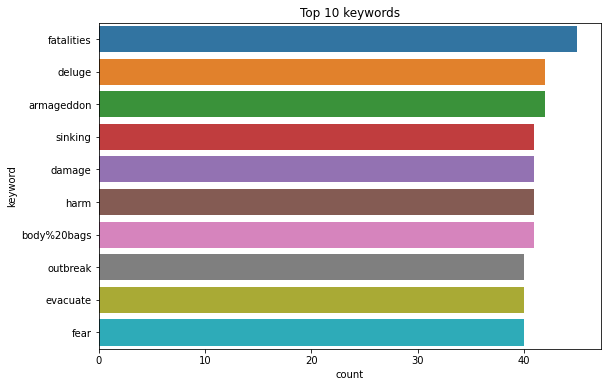

In [16]:
# Visualisation
plt.figure(figsize=(9,6))
sns.countplot(y=dataset.keyword, order = dataset.keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords')
plt.show()

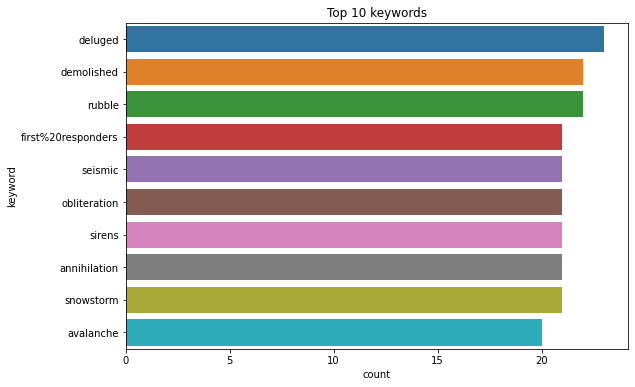

In [27]:
plt.figure(figsize=(9,6))
sns.countplot(y=dataset_test.keyword, order = dataset_test.keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords')
plt.show()

### Exploration de la  colonne 'text'.

In [28]:
dataset["text"].head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [29]:
textos = test_raw[test_raw['keyword'].notna()].iloc[25:30, [1,3]]
for t in textos.values:
    print(t)

['accident'
 '@DaveOshry @Soembie So if I say that I met her by accident this week- would you be super jelly Dave? :p']
['accident'
 'ACCIDENT - HIT AND RUN - COLD at 500 BLOCK OF SE VISTA TER GRESHAM OR [Gresham Police #PG15000044357] 10:35 #pdx911']
['accident'
 '@Calum5SOS this happened on accident but I like it http://t.co/QHmXuljSX9']
['accident'
 'Please donate and spread the word! A training accident left the pole-vaulter Kira GrÌ_nberg a paraplegic http://t.co/6MpnyCl8PK']
['aftershock'
 'Please like and share our new page for our Indoor Trampoline Park Aftershock opening this fall!! http://t.co/UgXhHErrxS']


### On voit qu 'il faut éliminer les url

# **3. Techniques de base NLP**

##### Avant de commencer les étapes de prétraitement du texte, nous devons connaître deux termes Corpus et Bag of word.
##### Corpus : est un ensemble de textes volumineux et structuré, nous pouvons le considérer comme une version simplifiée de nos données textuelles qui contiennent des données propres et avantageuses.
##### Bag of word : En pratique, le modèle Bag-of-words est principalement utilisé comme outil de génération de fonctionnalités. Après avoir transformé le texte en un "sac de mots", nous pouvons calculer différentes mesures pour caractériser le texte.

##### Nous allons maintenant effectuer les étapes suivantes pour prétraiter nos données de texte
 1.	Supprimer les mots indésirables
 2.	Transformer les mots en minuscules
 3.	Supprimer les stopwords
 4.	La stemmization ou racine des mots
 5.	Créer une matrice clairsemée (Bag of words)




 Nous voyons que notre colonne text contient des mots indésirables comme #, des chiffres, des ... , ?, !, etc...  qui ne seront pas utiles dans notre problématique donc nous n'obtiendrons que du texte pur sans aucune annotations ou nombres.

 Nous le ferons en spécifiant notre modèle à l'aide de la bibliothèque re.

## **Explorons le corpus et découvrons la différence entre les données textuelles brutes et les données nettoyées**

In [30]:
def supprimer_url(raw_text):
  clean_text = re.sub(r'https?://[\w\./]+\s*', '', raw_text, flags=re.MULTILINE)
  return clean_text


In [31]:
corpus  = []
pstem = PorterStemmer()
for i in range(dataset['text'].shape[0]): # boucle qui va de 0 au nombre de lignes 7613
    # nettoyer les urls
    tweet = dataset['text'][i]
    tweet = supprimer_url(tweet)
    tweet = html.unescape(tweet)
    # supprimer les mots indésirables
    tweet = re.sub("[^a-zA-Z]", ' ',tweet)
    # transformer les mots en minuscules
    tweet = tweet.lower()
    tweet = tweet.split()  
    # supprimer les stopwords , puis effectuer le stemming
    tweet = [pstem.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    # Ajouter le tweet nettoyé au corpus
    corpus.append(tweet)
        
print("Corpus created successfully")

Corpus created successfully


### on verifie

In [32]:
dataset['text'][20:40]

20                               this is ridiculous....
21                                    London is cool ;)
22                                          Love skiing
23                                What a wonderful day!
24                                             LOOOOOOL
25                       No way...I can't eat that shit
26                                Was in NYC last week!
27                                   Love my girlfriend
28                                            Cooool :)
29                                   Do you like pasta?
30                                             The end!
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
32    We always try to bring the heavy. #metal #RT h...
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...
34                   Crying out for more! Set me ablaze
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
36    @PhDSquares #mufc they've built so much hype a...
37    INEC Office in Abia Set Ablaze - http://t.

In [33]:
corpus[20:40]

['ridicul',
 'london cool',
 'love ski',
 'wonder day',
 'looooool',
 'way eat shit',
 'nyc last week',
 'love girlfriend',
 'cooool',
 'like pasta',
 'end',
 'bbcmtd wholesal market ablaz',
 'alway tri bring heavi metal rt',
 'africanbaz break news nigeria flag set ablaz aba',
 'cri set ablaz',
 'plu side look sky last night ablaz',
 'phdsquar mufc built much hype around new acquisit doubt set epl ablaz season',
 'inec offic abia set ablaz',
 'barbado bridgetown jamaica two car set ablaz santa cruz head st elizabeth polic superintend',
 'ablaz lord']

**Remarque :** La librairie de steaming(pstem) que j'ai utilisé coupe les lettres e dans certains mots (ex:"INEC Office in Abia Set Ablaze, remplacé par inec offic abia set ablaz") ou ("@bbcmtd Wholesale Markets ablaze,remplacé par bbcmtd wholesal market ablaz',) mais pour le reste le nettoyage est réussi.
Utiliser une autre librairie la prochaine fois

In [34]:
rawTexdata = dataset["text"].head(10)
cleanTexData = pd.DataFrame(corpus, columns=['text after cleaning']).head(10)
frames = [rawTexdata, cleanTexData]
result = pd.concat(frames, axis=1, sort=False)
result


,text,text after cleaning
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfir updat california hwi close direct due...
6,#flood #disaster Heavy rain causes flash flood...,flood disast heavi rain caus flash flood stree...
7,I'm on top of the hill and I can see a fire in...,top hill see fire wood
8,There's an emergency evacuation happening now ...,emerg evacu happen build across street
9,I'm afraid that the tornado is coming to our a...,afraid tornado come area


## **Import WordCloud  pour visualiser le nuage de mots avant et après nettoyage**

In [35]:
rawTexdata = [] # données brutes du texte

for i in range(len(corpus)):
               
    word = corpus[i]
    rawTexdata.append(word)
rawTexdata = ' '.join(rawTexdata)

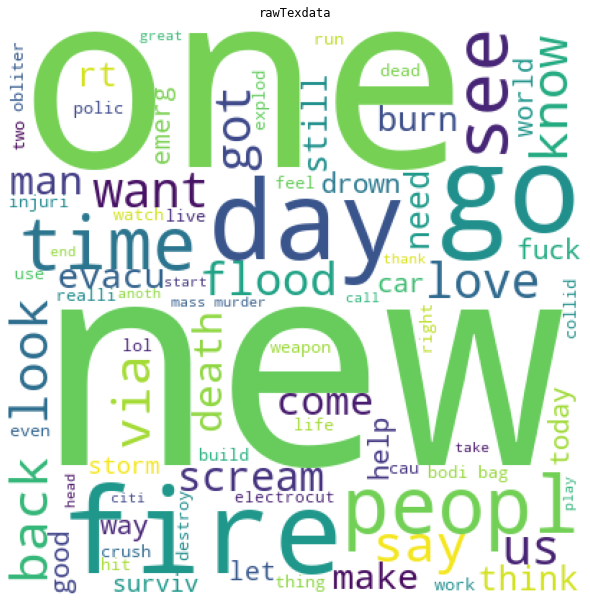

In [36]:
from wordcloud import WordCloud

rawTexdata = WordCloud(width = 400, height = 400,
                background_color ='white',
                min_font_size = 10).generate(rawTexdata)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(rawTexdata)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('rawTexdata', fontname = 'monospace')
plt.show('iframe')

In [37]:
cleanTexData= []

for i in range(len(corpus)):
               
    word = corpus[i]
    cleanTexData.append(word)
cleanTexData = ' '.join(cleanTexData)

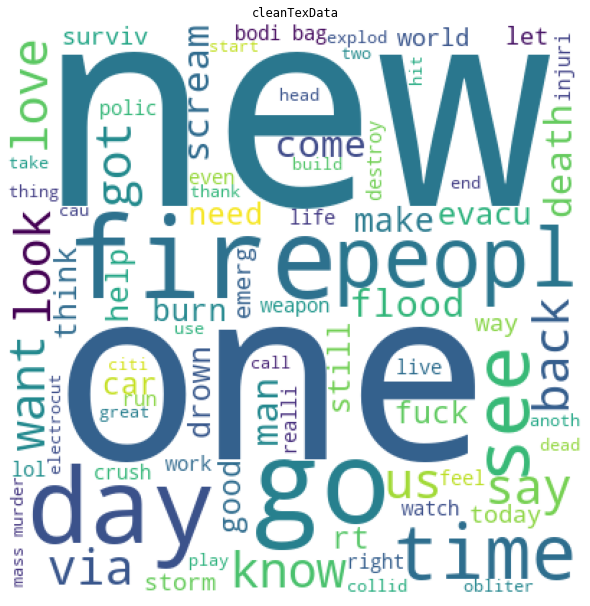

In [38]:
# from wordcloud import WordCloud

cleanTexData = WordCloud(width = 400, height = 400,
                background_color ='white',
                min_font_size = 10).generate(cleanTexData)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cleanTexData)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('cleanTexData', fontname = 'monospace')
plt.show('iframe')

## **On se retrouve bien avec des mots qui indiquent une catastrophe : fire, flood, death, scream, evac...**



## On crée un dictionnaire où key fait référence à word et value fait référence à word frequents dans tous les tweets::.


In [39]:
# créer notre dictionnaire

uniqueWordFrequents = {}
for tweet in corpus:
    for word in tweet.split():
        if(word in uniqueWordFrequents.keys()):
            uniqueWordFrequents[word] += 1
        else:
            uniqueWordFrequents[word] = 1
            
# convertir le dictionnaire en dataframe
uniqueWordFrequents = pd.DataFrame.from_dict( uniqueWordFrequents,orient='index',columns=['Word Frequent'])
uniqueWordFrequents.sort_values(by=['Word Frequent'], inplace=True, ascending=False)
uniqueWordFrequents.head(10)

,Word Frequent
like,411
fire,363
get,311
bomb,239
new,228
via,220
news,213
one,209
go,204
peopl,201


In [40]:
uniqueWordFrequents['Word Frequent'].unique()

array([411, 363, 311, 239, 228, 220, 213, 209, 204, 201, 183, 181, 180,
       178, 175, 169, 166, 164, 162, 156, 155, 153, 151, 145, 144, 143,
       137, 133, 132, 131, 130, 129, 128, 125, 124, 123, 121, 120, 119,
       118, 117, 116, 114, 113, 109, 108, 106, 105, 104, 103, 102, 101,
       100,  99,  98,  97,  95,  94,  93,  92,  91,  90,  89,  88,  87,
        86,  84,  83,  82,  79,  78,  77,  76,  75,  74,  73,  72,  71,
        70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,
        57,  56,  55,  54,  53,  52,  51,  50,  49,  48,  47,  46,  45,
        44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,  33,  32,
        31,  30,  29,  28,  27,  26,  25,  24,  23,  22,  21,  20,  19,
        18,  17,  16,  15,  14,  13,  12,  11,  10,   9,   8,   7,   6,
         5,   4,   3,   2,   1])

## **créer une sparce matrix( bagOFwords)**
Le sac de mots ne contient que des mots uniques dans le corpus

In [55]:
counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
bagOfWords = counVec.fit_transform(corpus).toarray()
bagOfWords

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Maintenant, nous allons construire nos modèles de Machine Learning.

### C'est un modèle de classification (sortie discrète Disaster ou not Disaster)

### Nous utiliserons donc les modèles de Classification suivants :



### •	Decision Tree Model(DecisionTreeClassifier)
### •	Logistic Regression Model:
### •	Support Vector Machine Model







### Avant de les utiliser, nous allons d'abord  diviser nos données entre train & test.

In [48]:
X = bagOfWords
y = dataset['target']
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X_train , X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=55, shuffle =True)
print(X_train.shape)
print('data splitting successfully')

X shape =  (7613, 13048)
y shape =  (7613,)
(6090, 13048)
data splitting successfully


In [49]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
y_train

6803    1
4015    1
3981    1
6169    0
1113    0
       ..
6685    0
968     0
4391    0
4762    0
4557    0
Name: target, Length: 6090, dtype: int64

## 4.1 Decision Tree Model

In [51]:
decisionTreeModel = DecisionTreeClassifier(criterion ='entropy',
                                           splitter= 'best',
                                           max_depth=None,
                                           random_state=55)
decisionTreeModel.fit(X_train,y_train)

print("Decision Tree Classifier Model run successfully")


Decision Tree Classifier Model run successfully


## 4.2 Logistic Regression Model

In [52]:
LogisticRegression = LogisticRegression(penalty='l2',
                                        solver='saga',
                                        random_state = 55)

LogisticRegression.fit(bagOfWords, dataset['target'])
print("LogisticRegression classifier model run successfully")

LogisticRegression classifier model run successfully


## 4.3 Support Vector Machine Model

In [53]:
SVClassifier = SVC(kernel= 'linear',
                   degree=3,
                   max_iter=10000,
                   C=2,
                   random_state = 55)
SVClassifier.fit(bagOfWords, dataset['target'])

print("SVClassifier model run successfully")

SVClassifier model run successfully


## 5 Evaluation des modèles

### Nous allons maintenant évaluer nos modèles en utilisant la métrique f1_score

In [54]:
#evaluation Details

models = [decisionTreeModel, LogisticRegression, SVClassifier]

for model in models:
    print(type(model),__name__,'Train Score is  : ',model.score(X_train,y_train))
    print(type(model),__name__,'Test Score  is  : ',model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    print(type(model).__name__,'F1 Score is     : ',f1_score(y_test,y_pred))
    print('...........................................................................')

<class 'sklearn.tree._classes.DecisionTreeClassifier'> __main__ Train Score is  :  0.9875205254515599
<class 'sklearn.tree._classes.DecisionTreeClassifier'> __main__ Test Score  is  :  0.7353906762967827
DecisionTreeClassifier F1 Score is     :  0.6666666666666667
...........................................................................
<class 'sklearn.linear_model._logistic.LogisticRegression'> __main__ Train Score is  :  0.9380952380952381
<class 'sklearn.linear_model._logistic.LogisticRegression'> __main__ Test Score  is  :  0.9487852921864741
LogisticRegression F1 Score is     :  0.9357495881383856
...........................................................................
<class 'sklearn.svm._classes.SVC'> __main__ Train Score is  :  0.9802955665024631
<class 'sklearn.svm._classes.SVC'> __main__ Test Score  is  :  0.9816152330925805
SVC F1 Score is     :  0.9773462783171522
...........................................................................


# CONCLUSION

Le score F1 peut être interprété comme une moyenne pondérée de la précision et du rappel, où un score F1 atteint sa meilleure valeur à 1 et son pire score à 0.
La contribution relative de la précision et du rappel au score F1 est égale:
La formule pour le score F1 est la suivante :

F1 = 2 * (precision * recall) / (precision + recall)

### on a un overfitting avec le modèle DecisionTreeClassifier avec 98%
### avec le modèle LogisticRegression score de 93% ET 94% sur le train_score et sur le test_score c'est super.
### avec le modèle SVM un score de 98% sur les 2.


